In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.LSTM(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
model.add(layers.GRU(256, return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# return states
output, state_h, state_c = layers.LSTM(64, return_state=True, name='encoder')(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

decoder_output = layers.LSTM(64, name='decoder')(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

In [5]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset stats to the initial_state 
# if no original initial state is present, it will use zero-states by default
lstm_layer.reset_states()

In [6]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


In [12]:
batch_size = 64
input_dim = 28
units = 64
output_size = 10

def build_model(allow_cudnn_kernel=True):
  # CuDNN is only available at the layer level
  if allow_cudnn_kernel:
    lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
  else:
    lstm_layer = keras.layers.RNN(
        keras.layers.LSTMCell(units), input_shape=(None, input_dim)
    )
  model = keras.models.Sequential(
      [
        lstm_layer,
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_size)
      ]
  )
  return model

In [13]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255., x_test/255.
sample, sample_label = x_train[0], y_train[0]

In [14]:
model = build_model(allow_cudnn_kernel=True)

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 10s 6ms/step - loss: 0.9229 - accuracy: 0.7070 - val_loss: 0.4870 - val_accuracy: 0.8523


In [15]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='sgd',
    metrics=['accuracy']
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 84s 88ms/step - loss: 2.3937 - accuracy: 0.3491 - val_loss: 3.6430 - val_accuracy: 0.1819


Predicted result is: [3], target result is 5


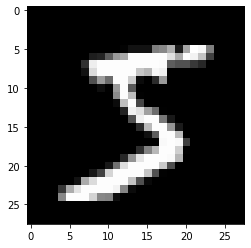

In [17]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
  cpu_model = build_model(allow_cudnn_kernel=False)
  cpu_model.set_weights(model.get_weights())
  result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
  print(
      "Predicted result is: %s, target result is %s" % (result.numpy(), sample_label)
  )
  plt.imshow(sample, cmap=plt.get_cmap("gray"))

In [21]:
class NestedCell(keras.layers.Layer):
  def __init__(self, unit_1, unit_2, unit_3, **kwargs):
    self.unit_1 = unit_1
    self.unit_2 = unit_2
    self.unit_3 = unit_3
    self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
    super(NestedCell, self).__init__(**kwargs)
  
  def build(self, input_shape):
    i1 = input_shape[0][1]
    i2 = input_shape[1][1]
    i3 = input_shape[1][2]

    self.kernel_1 = self.add_weight(
        shape=(i1, self.unit_1), initializer='uniform', name='kernel_1'
    )
    self.kernel_2_3 = self.add_weight(
        shape=(i2, i3, self.unit_2, self.unit_3),
        initializer='uniform',
        name='kernel_2_3'
    )

  def call(self, inputs, states):
    input_1, input_2 = tf.nest.flatten(inputs)
    s1, s2 = states

    output_1 = tf.matmul(input_1, self.kernel_1)
    output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
    state_1 = s1 + output_1
    state_2 = s2 + output_2_3

    output = (output_1, output_2_3)
    new_states = (state_1, state_2)

    return output, new_states

  def get_config(self):
    return {'unit_1':self.unit_1, 'unit_2':self.unit_2, 'unit_3':self.unit_3}

In [22]:
unit_1, unit_2, unit_3 = 10, 20, 30

i1, i2, i3 = 32, 64, 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer='adam', loss="mse", metrics=["accuracy"])

In [23]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 2s 33ms/step - loss: 0.7236 - rnn_6_loss: 0.2480 - rnn_6_1_loss: 0.4756 - rnn_6_accuracy: 0.1094 - rnn_6_1_accuracy: 0.0316
